In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold # Adding CrossValidation Boxplox
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, classification_report, confusion_matrix, RocCurveDisplay # Displaying ROC Curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC # Adding SVM Library
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree # Adding Decision Tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from scikeras.wrappers import KerasClassifier
from collections import defaultdict
from functools import partial
import shap

import cv2
import os
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

d:\Data Science\2025\ITDPA\eduml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Input and output
input_dir = Path(r"D:\Data Science\2025\ITDPA\passenger-screening-algorithm-challenge\stage1_a3daps")
output_dir = Path(r"D:\Data Science\2025\ITDPA\output_images")
output_dir.mkdir(exist_ok=True)

NUM_ANGLES = 64
NY = 660
NX = 512

def split_and_flip(volume):
    """Split each projection in half and horizontally flip both sides."""
    angles, H, W = volume.shape
    mid = W // 2
    new_volume = np.zeros_like(volume)
    for a in range(angles):
        slice_ = volume[a]
        left = np.fliplr(slice_[:, :mid])
        right = np.fliplr(slice_[:, mid:])
        new_volume[a] = np.hstack([left, right])
    return new_volume

def process_file(filepath, out_dir):
    """Load .a3daps file, process, and save 4 orientation PNGs."""
    print(f"Processing {filepath.name} ...")

    raw = np.fromfile(filepath, dtype=np.uint16)
    usable = NUM_ANGLES * NY * NX
    if raw.size < usable:
        print(f"Skipping {filepath.name} — Not enough voxels ({raw.size} < {usable})")
        return

    sino = raw[:usable].reshape(NUM_ANGLES, NY, NX)
    sino_v = (sino.astype(np.float32) - sino.min()) / (sino.ptp() + 1e-6)

    sino_fixed = split_and_flip(sino_v)

    orientations = {
        "front": sino_fixed[0],
        "back": sino_fixed[32],
        "right": sino_fixed[16],
        "left": sino_fixed[48],
    }

    for name, img in orientations.items():
        out_path = out_dir / f"{filepath.stem}_{name}.png"
        plt.imsave(out_path, img, cmap="gray", origin="lower")

    print(f"Saved: {filepath.stem}_[front/back/left/right].png")

print(f"Searching for .a3daps files in: {input_dir}")
files = list(input_dir.glob("*.a3daps"))

if not files:
    print("No .a3daps files found!")
else:
    for file in files:
        process_file(file, output_dir)

    print("\nDone! All files processed.")


In [2]:
class SecurityRiskPredictor:
    """
    Multi-model security risk prediction system for images
   
    Features extracted:
    - Color histograms (RGB distribution)
    - Edge detection features (Canny)
    - Texture features (GLCM - Gray Level Co-occurrence Matrix)
    - Deep features (from pre-trained CNN)
    - Object detection statistics
    - Brightness and contrast metrics
    """
    def __init__(self, image_size=(224,224), binary_classification=True):
        self.image_size = image_size
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
        if binary_classification:
            self.risk_categories = ['safe','threat']
        else:
            self.risk_categories = [
                'safe','suspicious','weapon_detected','unauthorized','hazard'
            ]
                   
    def extract_features(self, image_path, view_label=None):
        
        """
        Extract comprehensive features from an image
    
        Args:
        image_path: Path to image file
        view_label: 'front', 'back', 'left', or 'right' (optional)
    
        Returns:
        numpy array of features
        """
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image: {image_path}")
    
        # Resize for consistency
        img_resized = cv2.resize(img, self.image_size)
    
        # Feature list
        features = []
    
        # 1. Color Histogram Features (RGB - 48 features)
        for i, color in enumerate(['b', 'g', 'r']):
            hist = cv2.calcHist([img_resized], [i], None, [16], [0, 256])
            features.extend(hist.flatten())
    
        # 2. Edge Detection Features (8 features)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        edge_features = [
            np.mean(edges),
            np.std(edges),
            np.sum(edges > 0) / edges.size,
            np.percentile(edges, 25),
            np.percentile(edges, 50),
            np.percentile(edges, 75),
            np.percentile(edges, 90),
            np.percentile(edges, 95)
        ]
        features.extend(edge_features)
    
        # 3. Brightness and Contrast Features (6 features)
        brightness = np.mean(gray)
        contrast = np.std(gray)
        features.extend([
            brightness,
            contrast,
            np.min(gray),
            np.max(gray),
            np.percentile(gray, 25),
            np.percentile(gray, 75)
        ])
    
        # 4. Texture Features using GLCM (4 features)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        texture_features = [
            np.mean(np.abs(sobelx)),
            np.std(np.abs(sobelx)),
            np.mean(np.abs(sobely)),
            np.std(np.abs(sobely))
        ]
        features.extend(texture_features)
    
        # 5. Color Moments (9 features - mean, std, skew for each channel)
        for i in range(3):
            channel = img_resized[:, :, i]
            features.extend([
                np.mean(channel),
                np.std(channel),
                self._skewness(channel.flatten())
            ])
    
        # 6. Spatial features (4 features)
        h, w = img_resized.shape[:2]
        features.extend([
            h / w,
            h * w,
            np.mean(img_resized),
            np.std(img_resized)
        ])
    
        # 7. Add view feature (always 1 feature)
        view_mapping = {'front': 0, 'back': 1, 'left': 2, 'right': 3}
        if view_label is not None:
            features.append(view_mapping.get(view_label.lower(), -1))
        else:
            features.append(-1)  # or 0 if you prefer
   
        return np.array(features)
   
    def _skewness(self, data):
        """Calculate skewness of data"""
        mean = np.mean(data)
        std = np.std(data)
        if std == 0:
            return 0
        return np.mean(((data - mean) / std) ** 3)
   
    def build_cnn_model(self, input_shape=(224, 224, 3), num_classes=2):
        """
        Build CNN model for security risk classification
       
        Uses transfer learning with VGG16 as base
        """
        # Load pre-trained VGG16 without top layers
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
       
        # Freeze base model layers
        base_model.trainable = False
       
        # Build custom top layers
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.BatchNormalization(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.4),
            layers.BatchNormalization(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ])
       
        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=6e-4, weight_decay=1e-6),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='AUC'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
        )
        #https://www.youtube.com/watch?v=SaKOZ64Qnvo - Choosing the best learning rate
        return model
  
    def train_models(self, X_features, X_images, y, test_size=0.2):
        """
        Train all models: XGBoost, Random Forest, and CNN
       
        Args:
            X_features: Traditional features for XGBoost and RF
            X_images: Image arrays for CNN
            y: Labels
            test_size: Proportion of test data
        """
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Split data
        X_feat_train, X_feat_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
            X_features, X_images, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
        )


        # Scale features
        X_feat_train_scaled = self.scaler.fit_transform(X_feat_train)
        X_feat_test_scaled = self.scaler.transform(X_feat_test)
        
       
        print("=" * 80)
        print("TRAINING SECURITY RISK PREDICTION MODELS")
        print("=" * 80)
       
        # 1. Train XGBoost
        print("\n[1/4] Training XGBoost Model...")
        xgb_model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            random_state=42,
            eval_metric='logloss'
        )
        xgb_model.fit(
            X_feat_train_scaled, y_train,
            eval_set=[(X_feat_test_scaled, y_test)],
            verbose=False
        )
        self.models['xgboost'] = xgb_model
       
        # Evaluate XGBoost
        xgb_pred = xgb_model.predict(X_feat_test_scaled)
        xgb_acc = accuracy_score(y_test, xgb_pred)
        print(f"   ✓ XGBoost Accuracy: {xgb_acc:.4f}")
       
        # 2. Train Random Forest
        print("\n[2/4] Training Random Forest Model...")
        rf_model = RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(X_feat_train_scaled, y_train)
        self.models['random_forest'] = rf_model
       
        # Evaluate Random Forest
        rf_pred = rf_model.predict(X_feat_test_scaled)
        rf_acc = accuracy_score(y_test, rf_pred)
        print(f"   ✓ Random Forest Accuracy: {rf_acc:.4f}")

        # 3. Train SVM
        print("\n[3/4] Training SVM Model...")
        param_grid = {"C": [0.01,0.1,1,10,100], "gamma":[0.0001,0.001,0.01,0.1,1], "kernel":["rbf"]}
        grid = GridSearchCV(estimator = SVC(probability = True, random_state = 42), param_grid = param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1)
        
        #https://www.geeksforgeeks.org/machine-learning/svm-hyperparameter-tuning-using-gridsearchcv-ml - GridSearchCV Hyper tuning.
        grid.fit(X_feat_train_scaled, y_train)
        svm_model = grid.best_estimator_
        self.models["svm"] = svm_model

        # Evaluate SVM:
        svm_pred = svm_model.predict(X_feat_test_scaled)
        svm_acc = accuracy_score(y_test, svm_pred)
        print(f"   ✓ SVM Accuracy: {svm_acc:.4f}")
       
        # 5. Train CNN
        print("\n[4/4] Training CNN Model...")
        cnn_model = self.build_cnn_model(
            input_shape=(*self.image_size, 3),
            num_classes=len(self.risk_categories)
        )
       
        y_train_bin = y_train.astype(np.float32)
        y_test_bin  = y_test.astype(np.float32)
       
        # Callbacks
        early_stop = EarlyStopping(
            monitor='val_AUC',
            patience=20,
            restore_best_weights=True
        )
       
        reduce_lr = ReduceLROnPlateau(
            monitor='val_AUC',
            factor=0.5,
            patience=5,
            min_lr=1e-10
        )
       
        # Data augmentation
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2
        )
       
        # Train CNN
        batch_size = 96
        epochs = 150
        verbose = 1

        y_train_labels = y_train_bin

        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train_labels),
            y=y_train_labels
        )
        class_weights = dict(enumerate(class_weights))
        
        steps_per_epoch = len(X_img_train) // batch_size

        history = cnn_model.fit(
            datagen.flow(X_img_train, y_train_bin, batch_size=batch_size),
            validation_data=(X_img_test, y_test_bin),
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            class_weight=class_weights,
            callbacks=[early_stop, reduce_lr]
        )
        #https://www.geeksforgeeks.org/machine-learning/hyperparameter-tuning-fixing-overfitting-in-neural-networks - CNN Hypertuning
        #https://www.mdpi.com/2076-3417/14/19/9071
        
        self.models['cnn'] = cnn_model
       
        # Evaluate CNN
        cnn_pred = np.argmax(cnn_model.predict(X_img_test, verbose=0), axis=1)
        cnn_acc = accuracy_score(y_test, cnn_pred)
        print(f"   ✓ CNN Accuracy: {cnn_acc:.4f}")
       
        # Store test data for evaluation
        self.test_data = {
            'X_feat_test': X_feat_test_scaled,
            'X_img_test': X_img_test,
            'y_test': y_test
        }
       
        print("\n" + "=" * 80)
        print("MODEL TRAINING COMPLETED")
        print("=" * 80)
       
        return history
   
    def predict(self, image_path, use_ensemble=True):
        """
        Predict security risk for a single image
       
        Args:
            image_path: Path to image file
            use_ensemble: If True, combine predictions from all models
           
        Returns:
            Dictionary with predictions and confidence scores
        """
        # Extract features
        features = self.extract_features(image_path).reshape(1, -1)
        features_scaled = self.scaler.transform(features)
       
        # Load and preprocess image for CNN
        img = load_img(image_path, target_size=self.image_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
       
        predictions = {}
       
        # XGBoost prediction
        xgb_pred_proba = self.models['xgboost'].predict_proba(features_scaled)[0]
        (features_scaled)[0]
        xgb_pred = np.argmax(xgb_pred_proba)
        predictions['xgboost'] = {
            'class': self.label_encoder.inverse_transform([xgb_pred])[0],
            'confidence': float(xgb_pred_proba[xgb_pred]),
            'probabilities': {
                cat: float(prob)
                for cat, prob in zip(self.risk_categories, xgb_pred_proba)
            }
        }
       
        # Random Forest prediction
        rf_pred_proba = self.models['random_forest'].predict_proba(features_scaled)[0]
        rf_pred = np.argmax(rf_pred_proba)
        predictions['random_forest'] = {
            'class': self.label_encoder.inverse_transform([rf_pred])[0],
            'confidence': float(rf_pred_proba[rf_pred]),
            'probabilities': {
                cat: float(prob)
                for cat, prob in zip(self.risk_categories, rf_pred_proba)
            }
        }

        # SVM (Support Vector Machine) prediction
        svm_pred_proba = self.models['svm'].predict_proba(features_scaled)[0]
        svm_pred = np.argmax(svm_pred_proba)
        predictions['svm'] = {
            'class': self.label_encoder.inverse_transform([svm_pred])[0],
            'confidence': float(svm_pred_proba[svm_pred]),
            'probabilities': {
                cat: float(prob)
                for cat, prob in zip(self.risk_categories, svm_pred_proba)
            }
        }
       
        # CNN prediction
        cnn_pred_proba = self.models['cnn'].predict(img_array, verbose=0)[0]
        cnn_pred = np.argmax(cnn_pred_proba)
        predictions['cnn'] = {
            'class': self.label_encoder.inverse_transform([cnn_pred])[0],
            'confidence': float(cnn_pred_proba[cnn_pred]),
            'probabilities': {
                cat: float(prob)
                for cat, prob in zip(self.risk_categories, cnn_pred_proba)
            }
        }
       
        # Ensemble prediction (weighted average)
        if use_ensemble:
            weights = {'xgboost': 0.3, 'random_forest': 0.3, 'cnn': 0.4, "svm": 0.1} # "decision_tree": 0.1
            ensemble_proba = (
                weights['xgboost'] * xgb_pred_proba +
                weights['random_forest'] * rf_pred_proba +
                weights["svm"] * svm_pred_proba + # SVM:
                # weights["decision_tree"] * decision_tree_pred_proba + # Decision Tree:
                weights['cnn'] * cnn_pred_proba
            )
            ensemble_pred = np.argmax(ensemble_proba)
            predictions['ensemble'] = {
                'class': self.label_encoder.inverse_transform([ensemble_pred])[0],
                'confidence': float(ensemble_proba[ensemble_pred]),
                'probabilities': {
                    cat: float(prob)
                    for cat, prob in zip(self.risk_categories, ensemble_proba)
                }
            }
       
        return predictions
   
    def evaluate_models(self):
        """Generate comprehensive evaluation report"""
        if not hasattr(self, 'test_data'):
            print("No test data available. Please train models first.")
            return
       
        X_feat_test = self.test_data['X_feat_test']
        X_img_test = self.test_data['X_img_test']
        y_test = self.test_data['y_test']
       
        print("\n" + "=" * 80)
        print("MODEL EVALUATION REPORT")
        print("=" * 80)

        results = []

        # Evaluate each model
        for model_name in ['xgboost', 'random_forest', 'svm', 'cnn']:
            print(f"\n{'─' * 80}")
            print(f"{model_name.upper()} MODEL")
            print(f"{'─' * 80}")

            if model_name == "cnn":
                y_proba = self.models[model_name].predict(X_img_test, verbose=0).ravel()
                y_pred = (y_proba > 0.5).astype(int)
            else:
                model = self.models[model_name]
                y_pred = model.predict(X_feat_test)

                if hasattr(model, "predict_proba"):
                    y_proba = model.predict_proba(X_feat_test)[:, 1]
                else:
                    y_proba = model.decision_function(X_feat_test)
                    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        
            accuracy_Score = accuracy_score(y_test, y_pred)
            precision_Score = precision_score(y_test, y_pred, zero_division = 0)
            recall_Score = recall_score(y_test, y_pred, zero_division = 0)
            f1_Score = f1_score(y_test, y_pred, zero_division = 0)
            roc_auc_Score = roc_auc_score(y_test, y_proba)

            results.append({
                "Model": model_name.upper(),
                "Accuracy Score": accuracy_Score,
                "Precision Score": precision_Score,
                "Recall Score": recall_Score,
                "F1 Score": f1_Score,
                "ROC AUC Score": roc_auc_Score
                })
            
            print(f"Accuracy Score  : {accuracy_Score:.4f}")
            print(f"Precision Score : {precision_Score:.4f}")
            print(f"Recall Score    : {recall_Score:.4f}")
            print(f"F1 Score        : {f1_Score:.4f}")
            print(f"ROC AUC Score   : {roc_auc_Score:.4f}")
            
            confusion_Matrix = confusion_matrix(y_test, y_pred)
            print("/n Confusion Matrix")
            print(confusion_Matrix)
            
            sns.heatmap(confusion_Matrix, annot = True, fmt = "d", cmap = "Purples")
            plt.title(f"{model_name.upper()} - Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()
        
        results_dataframe = pd.DataFrame(results)
        print("\nSummary of All Models:\n", results_dataframe)

        plt.figure(figsize = (12, 8))
        results_melted = pd.melt(results_dataframe, id_vars="Model", var_name="Metric", value_name="Score")

        sns.barplot(data = results_melted, x = "Model", y = "Score", hue = "Metric")
        plt.title("Model Performance Comparison (Accuracy, Precision, Recall, F1, ROC_AUC)")
        plt.ylim(0, 1)
        plt.legend(loc = "lower right")
        plt.grid(True)
        plt.show()

        return results_dataframe
    
    def load_models(self, input_dir='models'):
        """Load previously saved models from disk"""
        print(f"\n[Loading models from '{input_dir}/']")
        
        # Load XGBoost
        xgb_model = xgb.Booster()
        xgb_model.load_model(f'{input_dir}/xgboost_model.json')
        self.models['xgboost'] = xgb_model

        # Load Random Forest
        with open(f'{input_dir}/random_forest_model.pkl', 'rb') as f:
            self.models['random_forest'] = pickle.load(f)

        # Load SVM
        with open(f'{input_dir}/svm.pkl', 'rb') as f:
            self.models['svm'] = pickle.load(f)

        # Load CNN
        self.models['cnn'] = tf.keras.models.load_model(f'{input_dir}/cnn_model.h5')

        # Load scaler and label encoder
        with open(f'{input_dir}/scaler.pkl', 'rb') as f:
            self.scaler = pickle.load(f)

        with open(f'{input_dir}/label_encoder.pkl', 'rb') as f:
            self.label_encoder = pickle.load(f)
        print("✓ All models successfully loaded from disk")
   
    def save_models(self, output_dir='models'):
        """Save trained models to disk"""
        os.makedirs(output_dir, exist_ok=True)
       
        # Save XGBoost
        self.models['xgboost'].save_model(f'{output_dir}/xgboost_model.json')
       
        # Save Random Forest
        with open(f'{output_dir}/random_forest_model.pkl', 'wb') as f:
            pickle.dump(self.models['random_forest'], f)
        
        # Save SVM:
        with open(f'{output_dir}/svm.pkl', 'wb') as f:
            pickle.dump(self.models['svm'], f)
       
        # Save CNN
        self.models['cnn'].save(f'{output_dir}/cnn_model.h5')
       
        # Save scaler and label encoder
        with open(f'{output_dir}/scaler.pkl', 'wb') as f:
            pickle.dump(self.scaler, f)
       
        with open(f'{output_dir}/label_encoder.pkl', 'wb') as f:
            pickle.dump(self.label_encoder, f)
       
        print(f"\n✓ Models saved to '{output_dir}/' directory")
   
    def load_models(self, model_dir='models'):
        """Load pre-trained models from disk"""
        # Load XGBoost
        xgb_model = xgb.XGBClassifier()
        xgb_model.load_model(f'{model_dir}/xgboost_model.json')
        self.models['xgboost'] = xgb_model
       
        # Load Random Forest
        with open(f'{model_dir}/random_forest_model.pkl', 'rb') as f:
            self.models['random_forest'] = pickle.load(f)
        
        #Load SVM:
        with open(f'{model_dir}/svm.pkl', 'rb') as f:
            self.models['svm'] = pickle.load(f)
       
        # Load CNN
        self.models['cnn'] = keras.models.load_model(f'{model_dir}/cnn_model.h5')
       
        # Load scaler and label encoder
        with open(f'{model_dir}/scaler.pkl', 'rb') as f:
            self.scaler = pickle.load(f)
       
        with open(f'{model_dir}/label_encoder.pkl', 'rb') as f:
            self.label_encoder = pickle.load(f)
       
        print(f"✓ Models loaded from '{model_dir}/' directory")

    def predict_multiview(self, image_paths, use_ensemble=True):
        """
        Predict security risk for multiple views of the same person.
        """
        all_probs = []

        for path in image_paths:
            pred = self.predict(path, use_ensemble=use_ensemble)
            all_probs.append(list(pred['ensemble']['probabilities'].values()))

        avg_proba = np.mean(all_probs, axis=0)
        final_class = self.label_encoder.inverse_transform([np.argmax(avg_proba)])[0]

        return final_class, avg_proba
    
def visualize_model_performance(model_name, y_test, y_pred, y_proba):
        
        """
        Visualizing perforamnce models for Random Forest, XGBoost, CNN, SVM
        Visual plots showing ROC Curves, Confusion Matrix, and Bar Charts for Accuracy, Precision, Recall, F1 Scores

        """

        plt.figure(figsize = (5, 5))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Purples")
        plt.title(f"{model_name} - Confusion Matrix")
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize = (6, 5))
        plt.plot(fpr, tpr, label = f"AUC = {roc_auc:.2f}")
        plt.plot([0,1],[0,1], "--", color = "gray")
        plt.title(f"{model_name} - ROC Curve")
        plt.legend()
        plt.show()

        scores = [
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred)
        ]
        sns.barplot(x = ["Accuracy", "Precision", "Recall", "F1"], y = scores, palette = "viridis")
        plt.title(f"{model_name} - Performance Scores")
        plt.ylim(0,1)
        plt.show()
        
def load_images_and_labels(root_dir, label_csv_path):
    """
    Load images, map front/back/left/right, and assign threat labels per ID.
    Works with combined CSVs from old and new formats.
    """
    import os
    import cv2
    import pandas as pd

    labels_df = pd.read_csv(label_csv_path)

    # Extract base ID for old and new CSVs
    labels_df['PersonID'] = labels_df['Id'].str.split('_').str[0]
    threat_ids = set(labels_df['PersonID'].unique())

    images = []
    image_paths = []
    view_labels = []
    threat_labels = []

    for filename in os.listdir(root_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root_dir, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to read image: {img_path}")
                continue
            img = cv2.resize(img, (224, 224))
            images.append(img)
            image_paths.append(img_path)

            # Map view
            lower_name = filename.lower()
            if "front" in lower_name:
                view_labels.append("front")
            elif "back" in lower_name:
                view_labels.append("back")
            elif "left" in lower_name:
                view_labels.append("left")
            elif "right" in lower_name:
                view_labels.append("right")
            else:
                view_labels.append("front")  # fallback

            # Assign threat label
            base_id = filename.split('_')[0]  # extract main ID
            threat_labels.append(1 if base_id in threat_ids else 0)

    # Quick stats
    print(f"✓ Loaded {len(images)} images")
    print(f"   Unique view labels: {set(view_labels)}")
    print(f"   Label counts (views): { {k: view_labels.count(k) for k in set(view_labels)} }")
    print(f"   Label counts (threats): { {k: threat_labels.count(k) for k in set(threat_labels)} }")

    return images, image_paths, view_labels, threat_labels

def Grad_cam_analysis(model, img, last_layer):    
    grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=[model.get_layer(last_layer).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img[np.newaxis])
        class_id = tf.argmax(preds[0])
        loss = preds[:,class_id]
    
    grads = tape.gradient(loss, conv_out)[0]
    weights = tf.reduce_mean(grads, axis=(0,1))
    cam = tf.reduce_sum(conv_out[0] * weights, axis=-1)

    heatmap = np.maximum(cam,0) / np.max(cam)
    return heatmap

In [3]:
def main():
    # Load images and labels
    root_dir = r"D:\Data Science\2025\ITDPA\output_images"
    #root_dir = r"D:\Data Science\2025\ITDPA\Under_sampling"
    label_csv_path = r"D:\Data Science\2025\ITDPA\combined_labels.csv"
    
    images, image_paths, view_labels, threat_labels = load_images_and_labels(root_dir, label_csv_path)
    
    # Initialize predictor
    predictor = SecurityRiskPredictor(image_size=(224, 224))
    
    # Extract features
    print("\n[Step 2] Extracting features from images...")
    X_features = []
    X_images = []

    for i, img_path in enumerate(image_paths):
        if i % 100 == 0:
            print(f"   Processing image {i+1}/{len(image_paths)}...")
        features = predictor.extract_features(img_path, view_label=view_labels[i])
        X_features.append(features)

        img = load_img(img_path, target_size=(224, 224))
        X_images.append(img_to_array(img) / 255.0)

    X_features = np.array(X_features)
    X_images = np.array(X_images)
    
    print(f"\n✓ Extracted features from {len(image_paths)} images")
    print(f"   Feature shape: {X_features.shape}")
    print(f"   Image shape: {X_images.shape}")

    # Train models (threat vs safe)
    print("\n[Step 3] Training machine learning models...")
    history = predictor.train_models(X_features, X_images, threat_labels)
    
    # Evaluate models
    print("\n[Step 4] Evaluating model performance...")
    predictor.evaluate_models()

    # Multi-view averaging for ID-level prediction
    id_to_paths = defaultdict(list)
    for path in image_paths:
        base_id = os.path.basename(path).split('_Zone')[0]
        id_to_paths[base_id].append(path)
    
    print("\n[Step 5] Multi-view evaluation per ID")
    for base_id, paths in id_to_paths.items():
        final_class, avg_proba = predictor.predict_multiview(paths)
        print(f"ID: {base_id}, Predicted Threat: {final_class}, Probabilities: {avg_proba}")
    
    # Save models
    print("\n[Step 6] Saving trained models...")
    predictor.save_models('models')

    """print("\n[Step 7] Evaluating Trained Models")
    predictor.load_models('models')
    predictor.evaluate_models()"""
    
    # === Additional: Compute all metrics for ML models ===
    print("\n[Step 7] Detailed metrics for each model")

    X_feat_test = predictor.test_data['X_feat_test']
    X_img_test = predictor.test_data['X_img_test']
    y_test = predictor.test_data['y_test']
    print(X_img_test[0].shape)

    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
        classification_report, confusion_matrix
    )
    
    roc_data = {}

    for model_name in ['xgboost', 'random_forest', 'svm', 'cnn']:
        print(f"\n{'='*50}\n{model_name.upper()} Metrics\n{'='*50}")
        
        if model_name == 'cnn':
            y_pred  = (y_proba > 0.5).astype(int)
            y_proba = predictor.models[model_name].predict(X_img_test, verbose=0).ravel()
        else:
            y_pred = predictor.models[model_name].predict(X_feat_test)
            y_proba = predictor.models[model_name].predict_proba(X_feat_test)[:,1]
        
        visualize_model_performance(model_name.upper(), y_test, y_pred, y_proba)
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        roc_data[model_name.upper()] = (fpr, tpr, roc_auc)

        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred, zero_division = 0):.4f}")
        print(f"Recall: {recall_score(y_test, y_pred, zero_division = 0):.4f}")
        print(f"F1-score: {f1_score(y_test, y_pred, zero_division = 0):.4f}")
        print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    
    plt.figure(figsize = (6, 5))
    for model_name, (fpr,tpr, roc_auc) in roc_data.items():
        plt.plot(fpr, tpr, label = f"{model_name}, AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1], "--", color = "gray")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.show()
    
    print("\n [Step 8] Decision Tree Comparison Plot")
    metrics_data = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": [], "ROC_AUC": []}
    decision_tree_model = DecisionTreeClassifier(max_depth = 10, random_state = 42)
    decision_tree_model.fit(X_feat_test, y_test)
    decision_tree_pred = decision_tree_model.predict(X_feat_test)
    decision_tree_proba = decision_tree_model.predict_proba(X_feat_test)[:, 1]
    metrics_data["Model"].append("Decision Tree")
    metrics_data["Accuracy"].append(accuracy_score(y_test, decision_tree_pred))
    metrics_data["Precision"].append(precision_score(y_test, decision_tree_pred))
    metrics_data["Recall"].append(recall_score(y_test, decision_tree_pred))
    metrics_data["F1"].append(f1_score(y_test, decision_tree_pred))
    metrics_data["ROC_AUC"].append(roc_auc_score(y_test, decision_tree_proba))

    for model_name in ["xgboost", "random_forest", "svm", "cnn"]:
        if model_name == "cnn":
            y_pred  = (y_proba > 0.5).astype(int)
            y_proba = predictor.models[model_name].predict(X_img_test, verbose=0).ravel()
        else:
            y_pred = predictor.models[model_name].predict(X_feat_test)
            y_proba = predictor.models[model_name].predict_proba(X_feat_test)[:,1]
        
        metrics_data["Model"].append(model_name.upper())
        metrics_data["Accuracy"].append(accuracy_score(y_test, y_pred))
        metrics_data["Precision"].append(precision_score(y_test, y_pred))
        metrics_data["Recall"].append(recall_score(y_test, y_pred))
        metrics_data["F1"].append(f1_score(y_test, y_pred))
        metrics_data["ROC_AUC"].append(roc_auc_score(y_test, y_pred))
    
    metrics_dataframe = pd.DataFrame(metrics_data).set_index("Model")
    metrics_dataframe.plot(kind = "bar", figsize = (10, 6))
    plt.title("Decision Tree vs Other Models - Performance Comparison")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.grid(axis = "y")
    plt.show()

    print("\n [Step 9] Performing Cross-Validation Analysis")
    cnn_builder = partial(predictor.build_cnn_model, input_shape=(224,224,3), num_classes=2)

    model_cross_validation_analysis = {
        "Random Forest Classifier": RandomForestClassifier(n_estimators = 200, max_depth = 15, random_state = 42, n_jobs = -1),
        "XGBoost": xgb.XGBClassifier(n_estimators = 200, max_depth = 6, learning_rate = 0.1, subsamples = 0.8, colsample_bytree = 0.8, 
                                     objective = "binary:logistic", eval_metric = "logloss", random_state = 42),
        "SVM": SVC(kernel = "rbf", probability = True, random_state = 42),
        "CNN": KerasClassifier(model=cnn_builder, epochs=10, batch_size=32, verbose=0),
        "Decision Tree": DecisionTreeClassifier(max_depth = 10, random_state = 42)
    }

    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    cross_validation_analysis_results = []
    for model_name, model, in model_cross_validation_analysis.items():
        print(f"\n {model_name}")
        
        if model_name == "CNN":
            X_data = X_img_test
        else:
            X_data = X_feat_test
        
        accuracy_score_result = cross_val_score(model, X_data, y_test, cv = kfold, scoring = "accuracy")
        precision_score_result = cross_val_score(model, X_data, y_test, cv = kfold, scoring = "precision")
        recall_score_result = cross_val_score(model, X_data, y_test, cv = kfold, scoring = "recall")
        f1_score_result = cross_val_score(model, X_data, y_test, cv = kfold, scoring = "f1")
        roc_auc_score_result = cross_val_score(model, X_data, y_test, cv = kfold, scoring = "roc_auc")

        cross_validation_analysis_results.append({
            "Model": model_name,
            "Accuracy": accuracy_score_result,
            "Precision": precision_score_result,
            "Recall": recall_score_result,
            "F1": f1_score_result,
            "ROC AUC": roc_auc_score_result
        })

        print(f" Mean Accuracy Score: {np.mean(accuracy_score_result):.4f} + {np.std(accuracy_score_result):.4f}")
        print(f" Mean F1 Score: {np.mean(f1_score_result):.4f} + {np.std(f1_score_result):.4f}")
        print(f" Mean ROC_AUC: {np.mean(roc_auc_score_result):.4f} + {np.std(roc_auc_score_result):.4f}")

        metrics_data = []
        for res in cross_validation_analysis_results:
            for metric in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]:
                if metric in res:  # only loop if present
                    for score in res[metric]:
                        metrics_data.append({"Model": res["Model"], "Metric": metric, "Score": score})
        
        cross_validation_analysis_dataframe = pd.DataFrame(metrics_data)

        plt.figure(figsize = (15, 12))
        sns.boxplot(data = cross_validation_analysis_dataframe, x = "Metric", y = "Score", hue = "Model", palette = "Set2")
        plt.title("Cross-Validation Stability Across Models")
        plt.ylim(0, 1)
        plt.legend(title = "Model")
        plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
        plt.show()
        
    print("\n [Step 10] SHAP and Grad-CAM Analysis")
    X_feat_test = predictor.test_data['X_feat_test']
    X_img_test = predictor.test_data['X_img_test']
    y_test = predictor.test_data['y_test']
    predictor.load_models('models')
    for name, model in predictor.models.items():
        print(f"Running: {name}")
        
        if name in ("xgboost", "random_forest"):
            sample = shap.sample(X_feat_test, 500, random_state=42)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(sample)
            shap.summary_plot(shap_values, sample)
            
        elif name == "svm":
            sample = shap.sample(X_feat_test, 500, random_state=42)
            background = shap.sample(sample, 100)
            explainer = shap.KernelExplainer(model.predict_proba, background)
            shap_values = explainer.shap_values(sample[:50])
            shap.summary_plot(shap_values, sample[:50])
            
        elif name == "cnn":
            if isinstance(model, tf.keras.Sequential):
                base_model = model.layers[0]
                x = base_model.output
                
                for layer in model.layers[1:]:
                    x = layer(x)
                model = tf.keras.Model(inputs=base_model.input, outputs=x)
                predictor.models["cnn"] = model
            
            dummy_input = np.expand_dims(X_img_test[0], axis=0) #to intialize the model with dummy data 
            _ = model(dummy_input)

            last_layer = None
            stack = list(reversed(model.layers))
            while stack:
                layer = stack.pop()
                if hasattr(layer, "layers"):
                    stack.extend(reversed(layer.layers))
                if isinstance(layer, tf.keras.layers.Conv2D):
                    last_layer = layer.name
            
            print(f"Last layer name in CNN: {last_layer}")

            img = X_img_test[0]
            heat = Grad_cam_analysis(model, img, last_layer)
            heat = cv2.resize(heat, (img.shape[1], img.shape[0]))
            heat = np.expand_dims(heat, axis=-1)
            heat = np.repeat(heat, 3, axis=-1)
            overlay = np.clip(0.4*heat + img, 0, 1)
            plt.imshow(overlay)
            plt.axis("off")
            plt.show()
            
        else:
            print(f"unknown model: {name}")

✓ Loaded 5672 images
   Unique view labels: {'right', 'back', 'left', 'front'}
   Label counts (views): {'right': 1418, 'back': 1418, 'left': 1418, 'front': 1418}
   Label counts (threats): {0: 4608, 1: 1064}

[Step 2] Extracting features from images...
   Processing image 1/5672...
   Processing image 101/5672...
   Processing image 201/5672...
   Processing image 301/5672...
   Processing image 401/5672...
   Processing image 501/5672...
   Processing image 601/5672...
   Processing image 701/5672...
   Processing image 801/5672...
   Processing image 901/5672...
   Processing image 1001/5672...
   Processing image 1101/5672...
   Processing image 1201/5672...
   Processing image 1301/5672...
   Processing image 1401/5672...
   Processing image 1501/5672...
   Processing image 1601/5672...
   Processing image 1701/5672...
   Processing image 1801/5672...
   Processing image 1901/5672...
   Processing image 2001/5672...
   Processing image 2101/5672...
   Processing image 2201/5672...

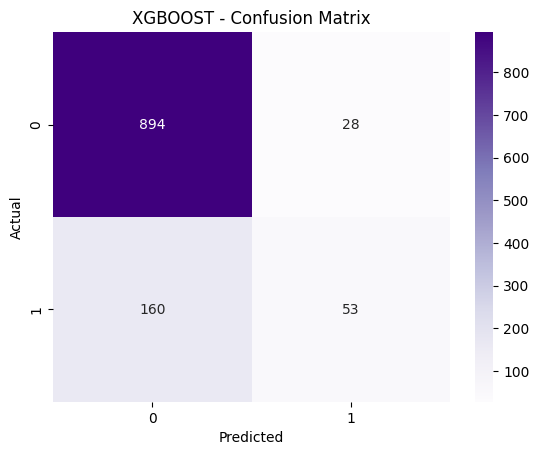


────────────────────────────────────────────────────────────────────────────────
RANDOM_FOREST MODEL
────────────────────────────────────────────────────────────────────────────────
Accuracy Score  : 0.8264
Precision Score : 0.7667
Recall Score    : 0.1080
F1 Score        : 0.1893
ROC AUC Score   : 0.7644
/n Confusion Matrix
[[915   7]
 [190  23]]


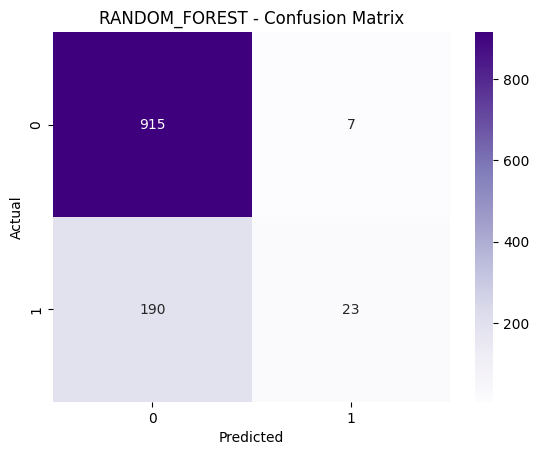


────────────────────────────────────────────────────────────────────────────────
SVM MODEL
────────────────────────────────────────────────────────────────────────────────
Accuracy Score  : 0.8423
Precision Score : 0.7297
Recall Score    : 0.2535
F1 Score        : 0.3763
ROC AUC Score   : 0.7349
/n Confusion Matrix
[[902  20]
 [159  54]]


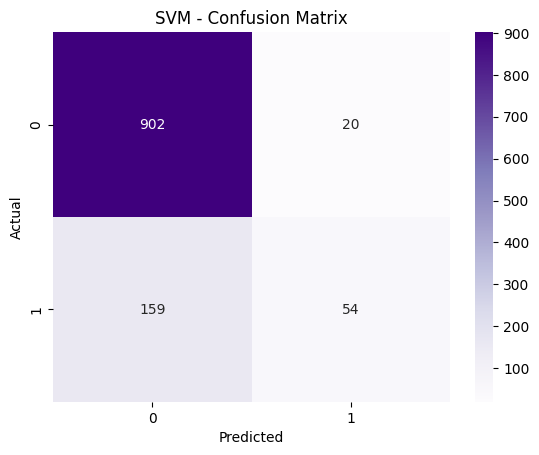


────────────────────────────────────────────────────────────────────────────────
CNN MODEL
────────────────────────────────────────────────────────────────────────────────
Accuracy Score  : 0.8053
Precision Score : 0.4167
Recall Score    : 0.0939
F1 Score        : 0.1533
ROC AUC Score   : 0.6638
/n Confusion Matrix
[[894  28]
 [193  20]]


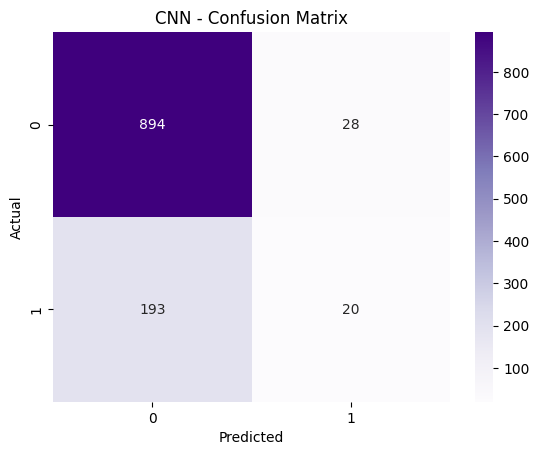


Summary of All Models:
            Model  Accuracy Score  Precision Score  Recall Score  F1 Score  \
0        XGBOOST        0.834361         0.654321      0.248826  0.360544   
1  RANDOM_FOREST        0.826432         0.766667      0.107981  0.189300   
2            SVM        0.842291         0.729730      0.253521  0.376307   
3            CNN        0.805286         0.416667      0.093897  0.153257   

   ROC AUC Score  
0       0.772749  
1       0.764418  
2       0.734895  
3       0.663790  


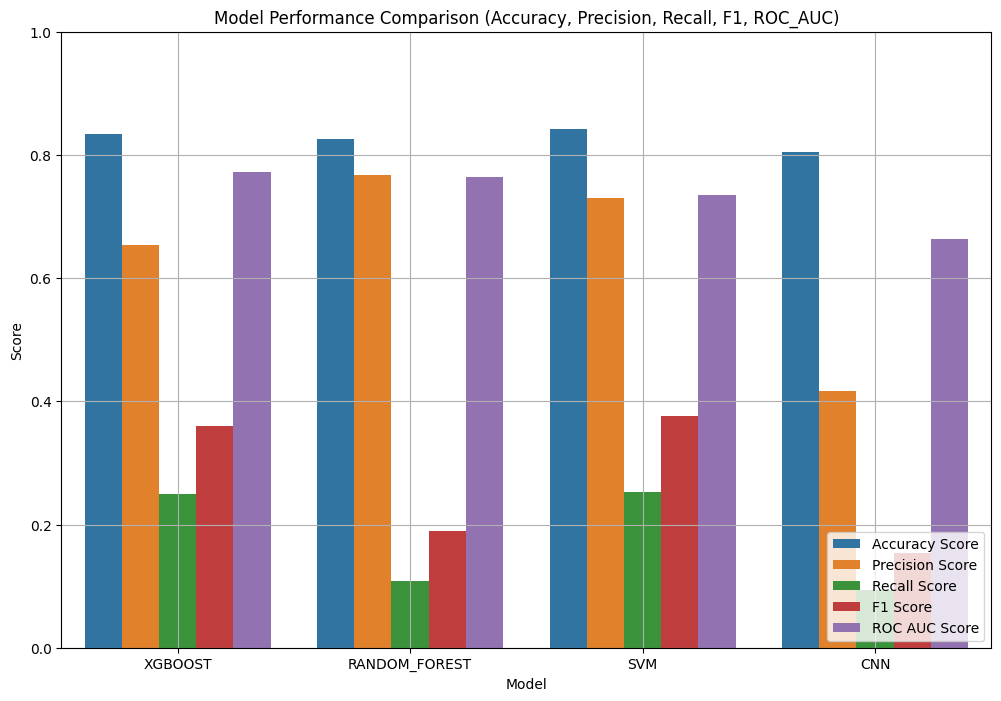


[Step 5] Multi-view evaluation per ID
ID: 00360f79fd6e02781457eda48f85da90_back.png, Predicted Threat: 0, Probabilities: [0.82445459 0.23038769]
ID: 00360f79fd6e02781457eda48f85da90_front.png, Predicted Threat: 0, Probabilities: [0.8299629  0.23156482]
ID: 00360f79fd6e02781457eda48f85da90_left.png, Predicted Threat: 0, Probabilities: [0.82370785 0.2341712 ]
ID: 00360f79fd6e02781457eda48f85da90_right.png, Predicted Threat: 0, Probabilities: [0.74281526 0.31288891]
ID: 0043db5e8c819bffc15261b1f1ac5e42_back.png, Predicted Threat: 0, Probabilities: [0.78795286 0.30011796]
ID: 0043db5e8c819bffc15261b1f1ac5e42_front.png, Predicted Threat: 0, Probabilities: [0.83522772 0.24730415]
ID: 0043db5e8c819bffc15261b1f1ac5e42_left.png, Predicted Threat: 0, Probabilities: [0.82204097 0.2387026 ]
ID: 0043db5e8c819bffc15261b1f1ac5e42_right.png, Predicted Threat: 0, Probabilities: [0.83862427 0.21426836]
ID: 0050492f92e22eed3474ae3a6fc907fa_back.png, Predicted Threat: 0, Probabilities: [0.77442722 0.3148


✓ Models saved to 'models/' directory

[Step 7] Detailed metrics for each model
(224, 224, 3)

XGBOOST Metrics


<Figure size 500x500 with 0 Axes>

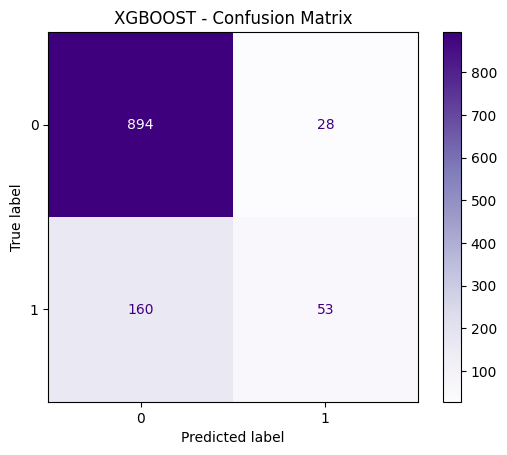

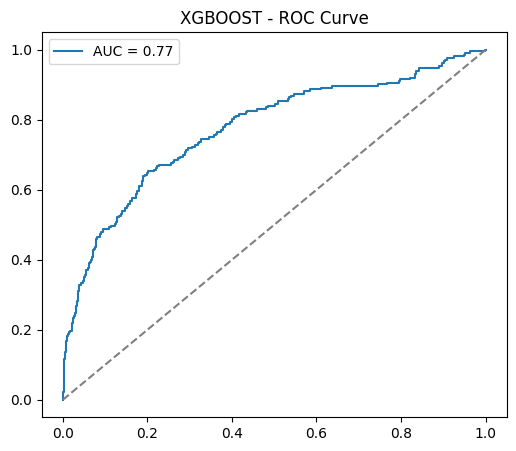

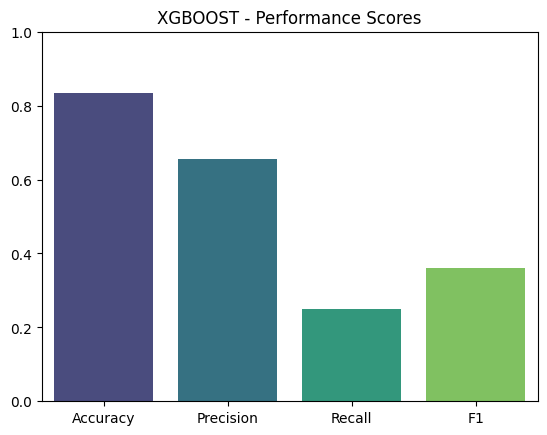

Confusion Matrix:
 [[894  28]
 [160  53]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8482    0.9696    0.9049       922
           1     0.6543    0.2488    0.3605       213

    accuracy                         0.8344      1135
   macro avg     0.7513    0.6092    0.6327      1135
weighted avg     0.8118    0.8344    0.8027      1135

Accuracy: 0.8344
Precision: 0.6543
Recall: 0.2488
F1-score: 0.3605
ROC-AUC: 0.7727

RANDOM_FOREST Metrics


<Figure size 500x500 with 0 Axes>

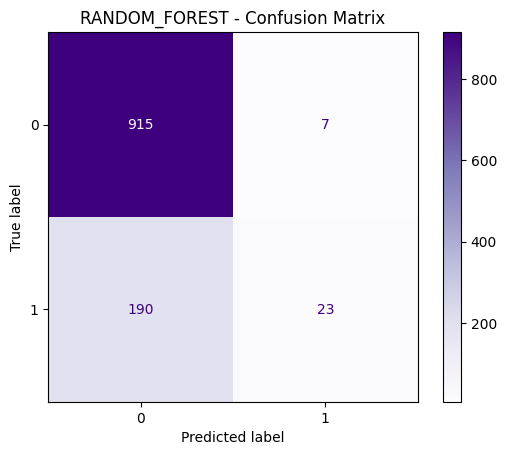

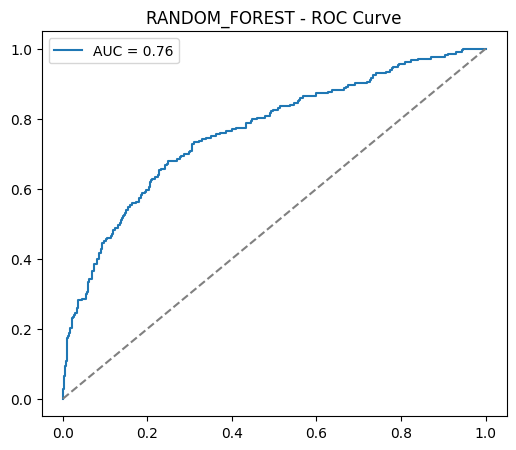

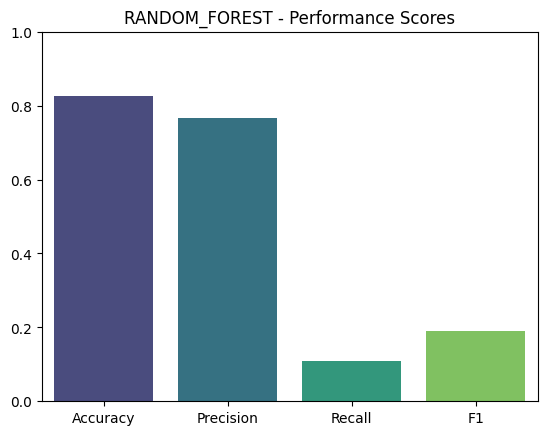

Confusion Matrix:
 [[915   7]
 [190  23]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8281    0.9924    0.9028       922
           1     0.7667    0.1080    0.1893       213

    accuracy                         0.8264      1135
   macro avg     0.7974    0.5502    0.5461      1135
weighted avg     0.8165    0.8264    0.7689      1135

Accuracy: 0.8264
Precision: 0.7667
Recall: 0.1080
F1-score: 0.1893
ROC-AUC: 0.7644

SVM Metrics


<Figure size 500x500 with 0 Axes>

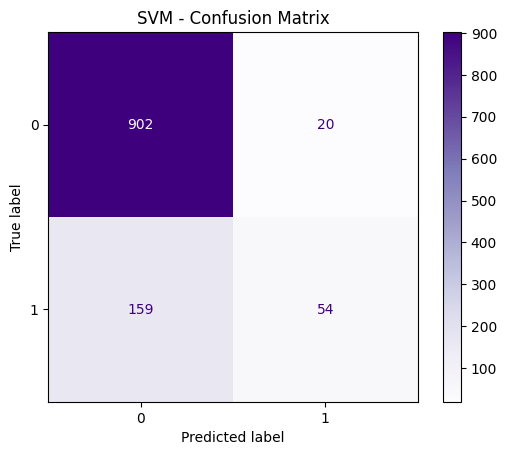

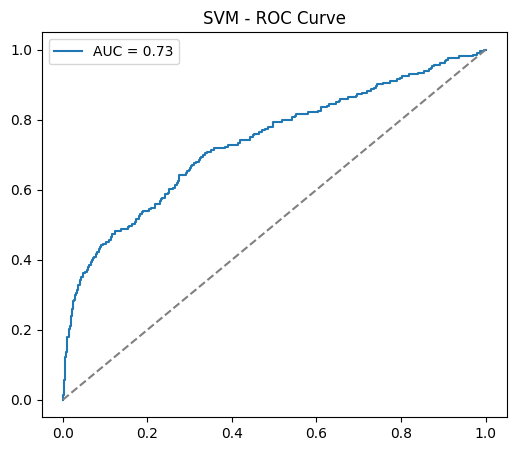

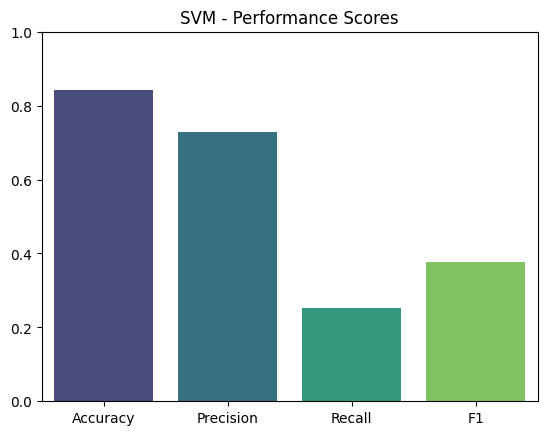

Confusion Matrix:
 [[902  20]
 [159  54]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8501    0.9783    0.9097       922
           1     0.7297    0.2535    0.3763       213

    accuracy                         0.8423      1135
   macro avg     0.7899    0.6159    0.6430      1135
weighted avg     0.8275    0.8423    0.8096      1135

Accuracy: 0.8423
Precision: 0.7297
Recall: 0.2535
F1-score: 0.3763
ROC-AUC: 0.7349

CNN Metrics


<Figure size 500x500 with 0 Axes>

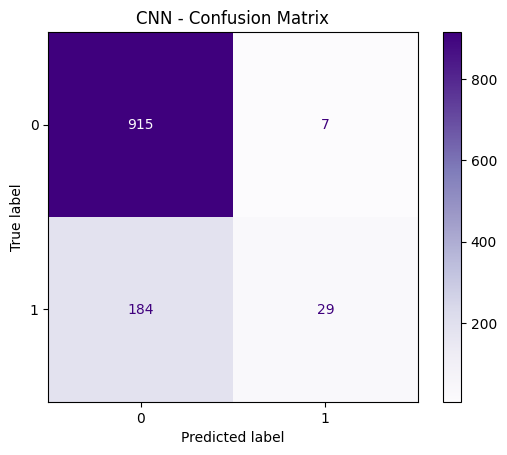

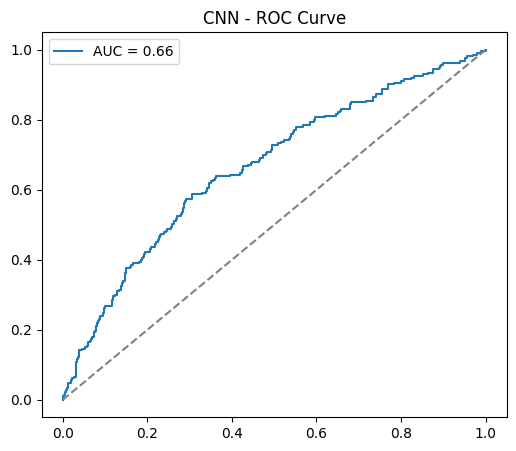

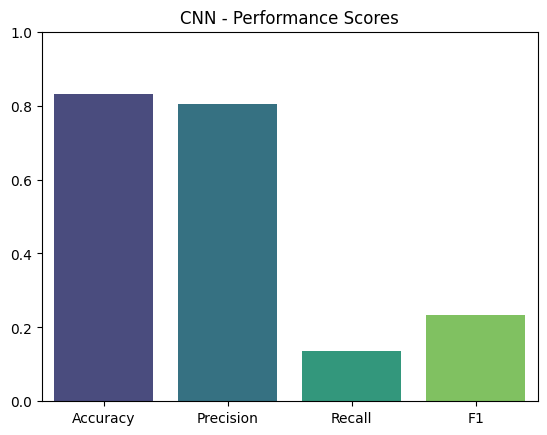

Confusion Matrix:
 [[915   7]
 [184  29]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8326    0.9924    0.9055       922
           1     0.8056    0.1362    0.2329       213

    accuracy                         0.8317      1135
   macro avg     0.8191    0.5643    0.5692      1135
weighted avg     0.8275    0.8317    0.7793      1135

Accuracy: 0.8317
Precision: 0.8056
Recall: 0.1362
F1-score: 0.2329
ROC-AUC: 0.6638


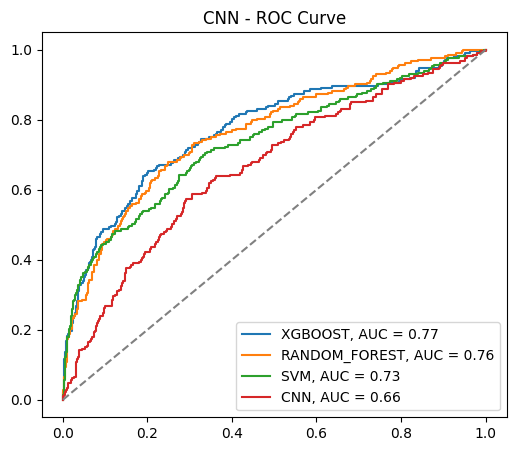


 [Step 8] Decision Tree Comparison Plot


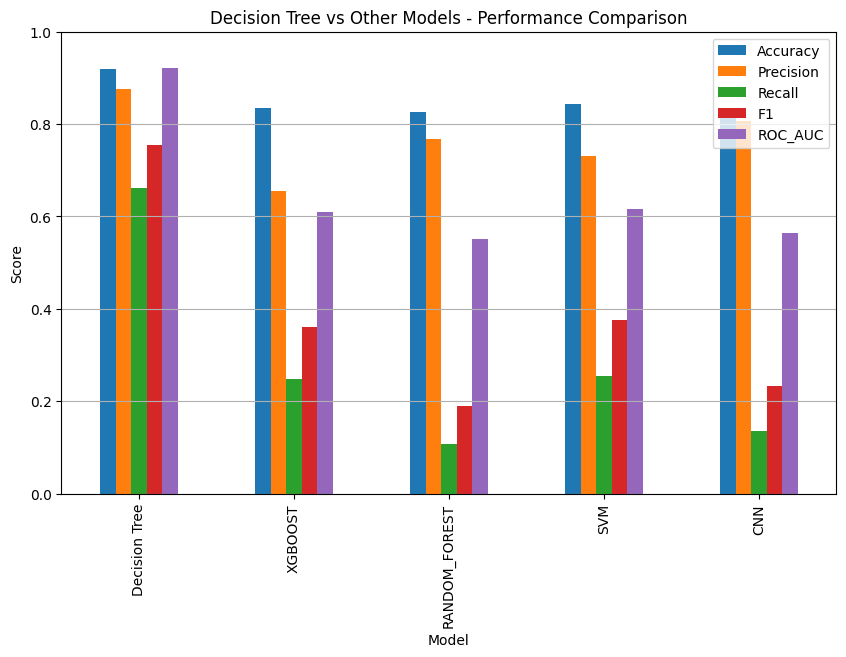


 [Step 9] Performing Cross-Validation Analysis

 Random Forest Classifier
 Mean Accuracy Score: 0.8097 + 0.0076
 Mean F1 Score: 0.0846 + 0.0273
 Mean ROC_AUC: 0.6848 + 0.0312


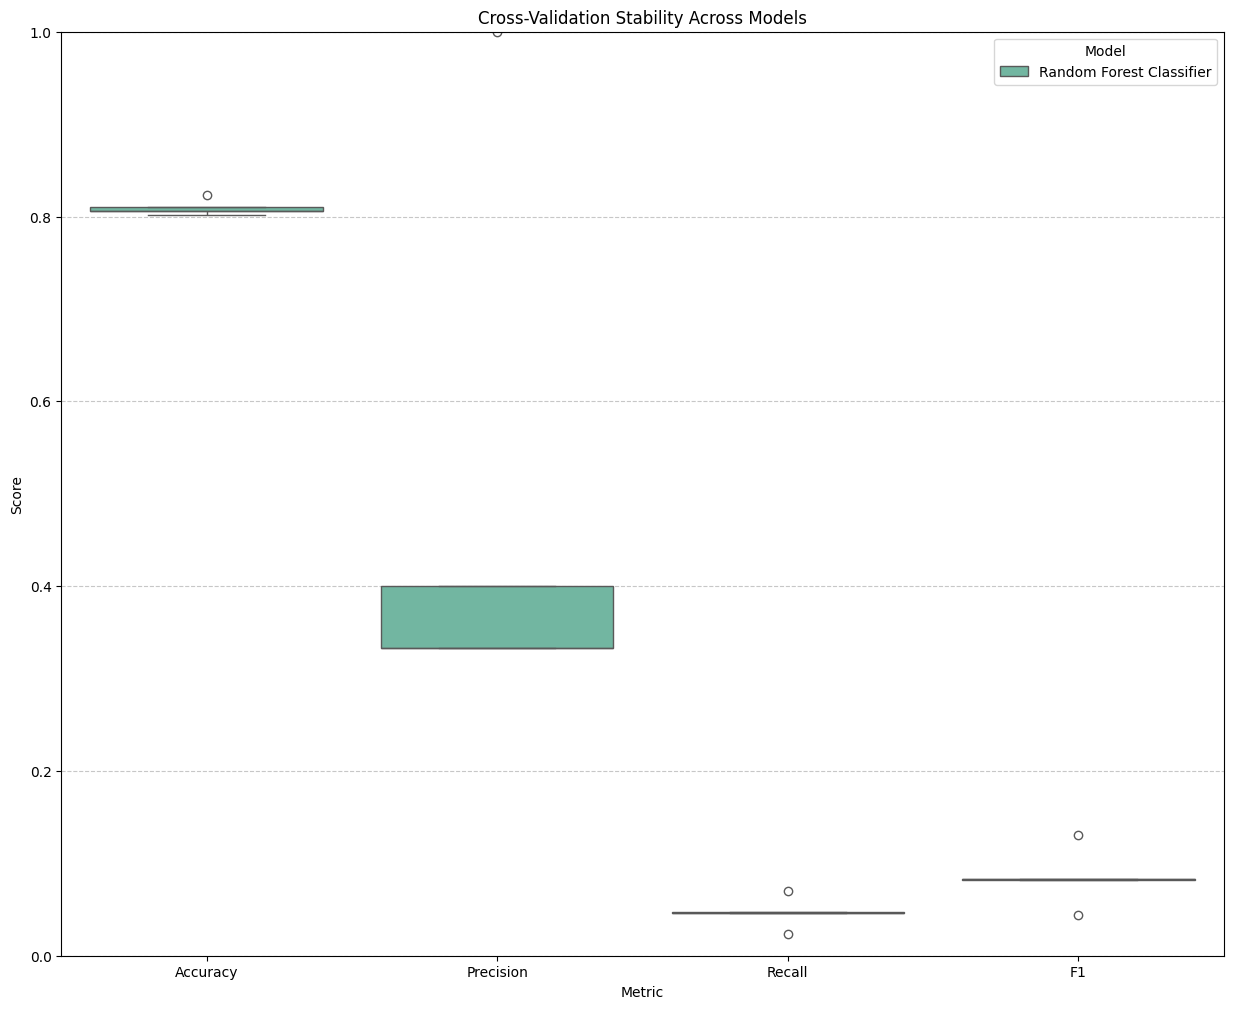


 XGBoost
 Mean Accuracy Score: 0.8159 + 0.0065
 Mean F1 Score: 0.2534 + 0.0551
 Mean ROC_AUC: 0.6971 + 0.0574


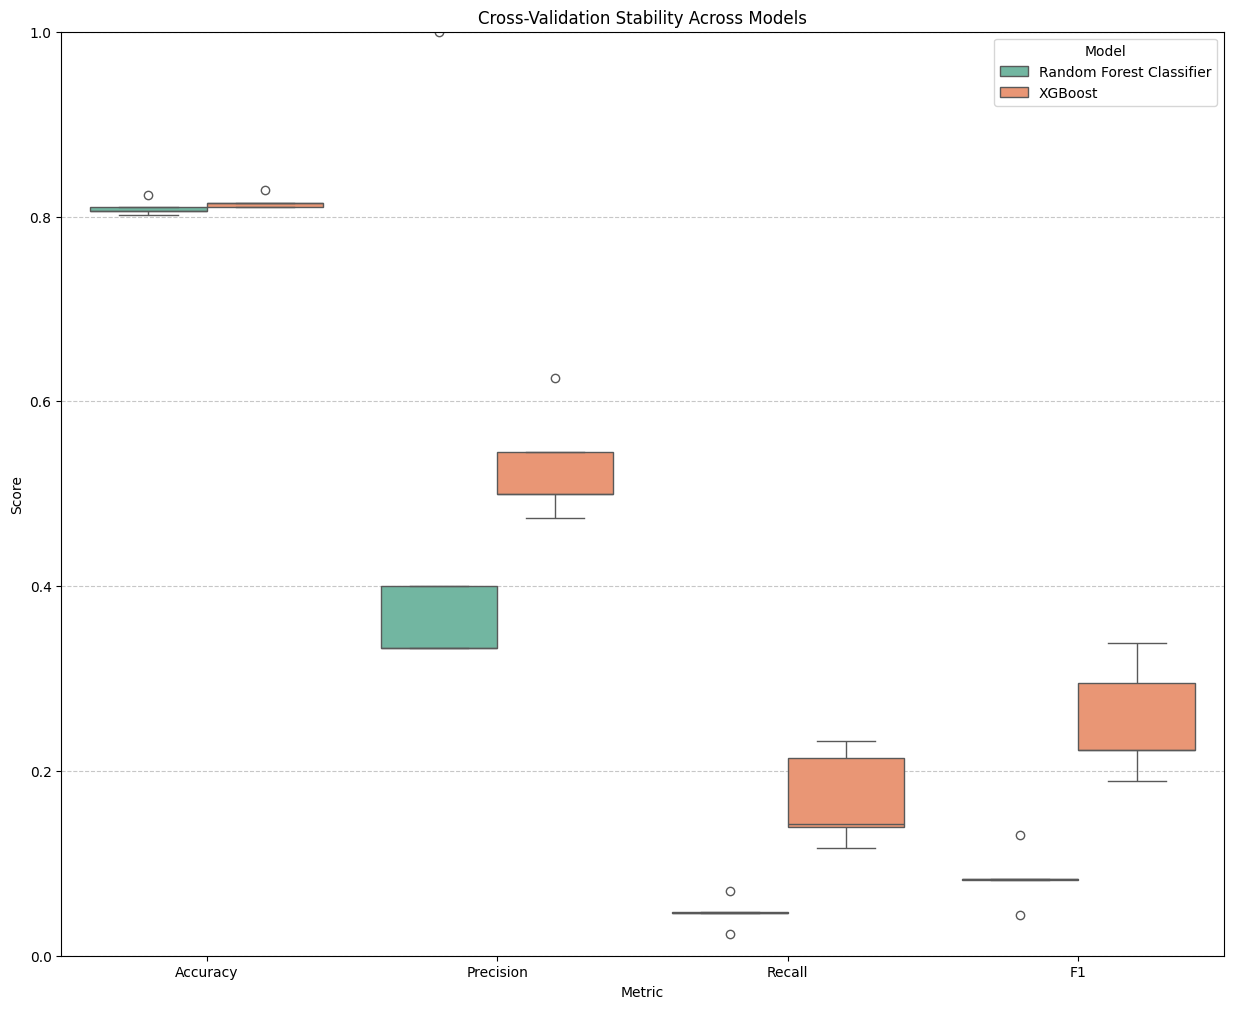


 SVM
 Mean Accuracy Score: 0.8123 + 0.0022
 Mean F1 Score: 0.0000 + 0.0000
 Mean ROC_AUC: 0.6882 + 0.0101


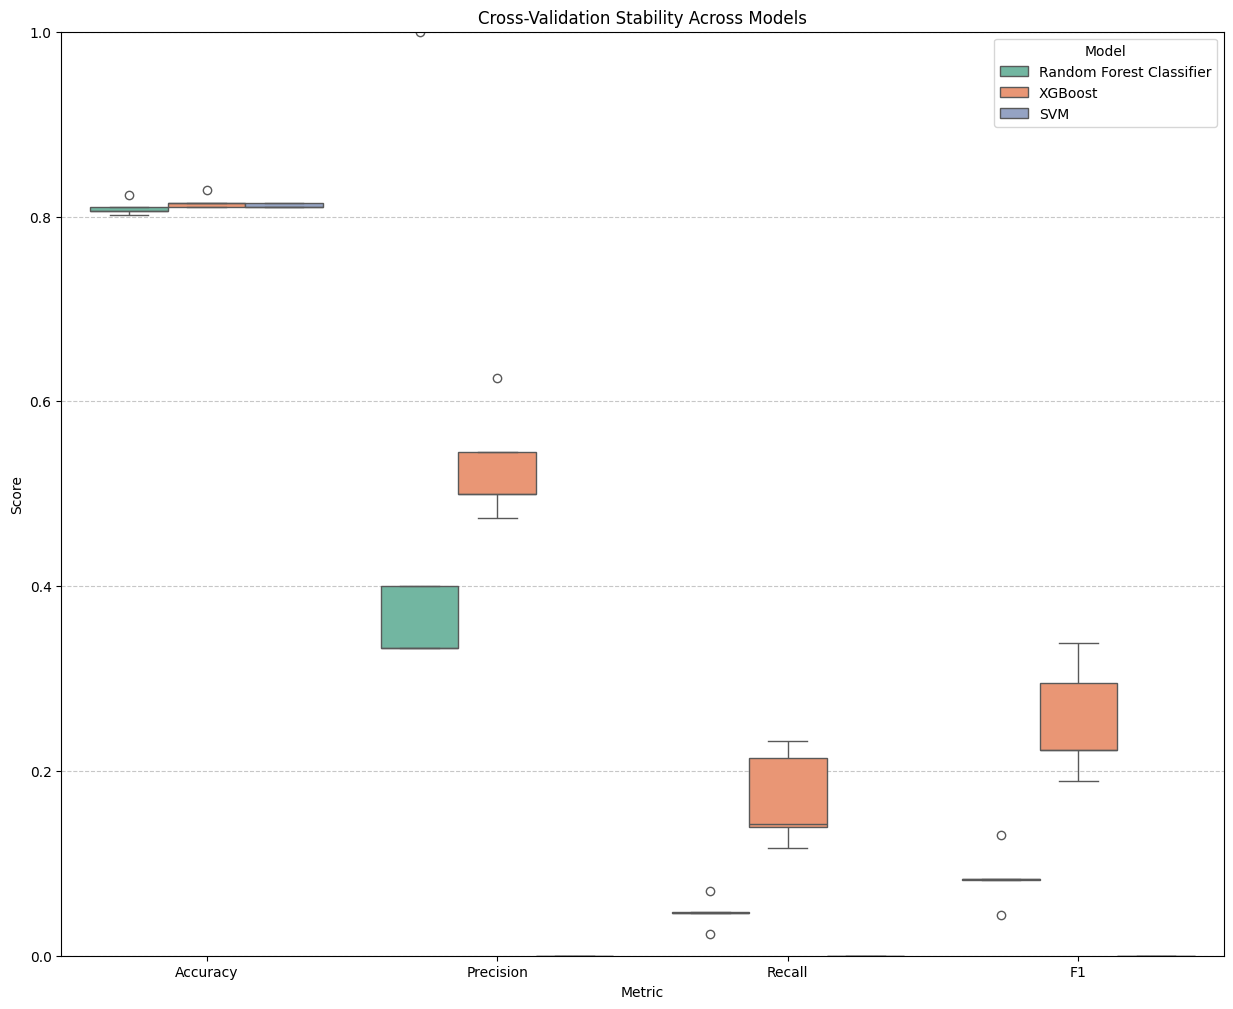


 CNN


 Mean Accuracy Score: 0.8123 + 0.0022
 Mean F1 Score: 0.0000 + 0.0000
 Mean ROC_AUC: nan + nan


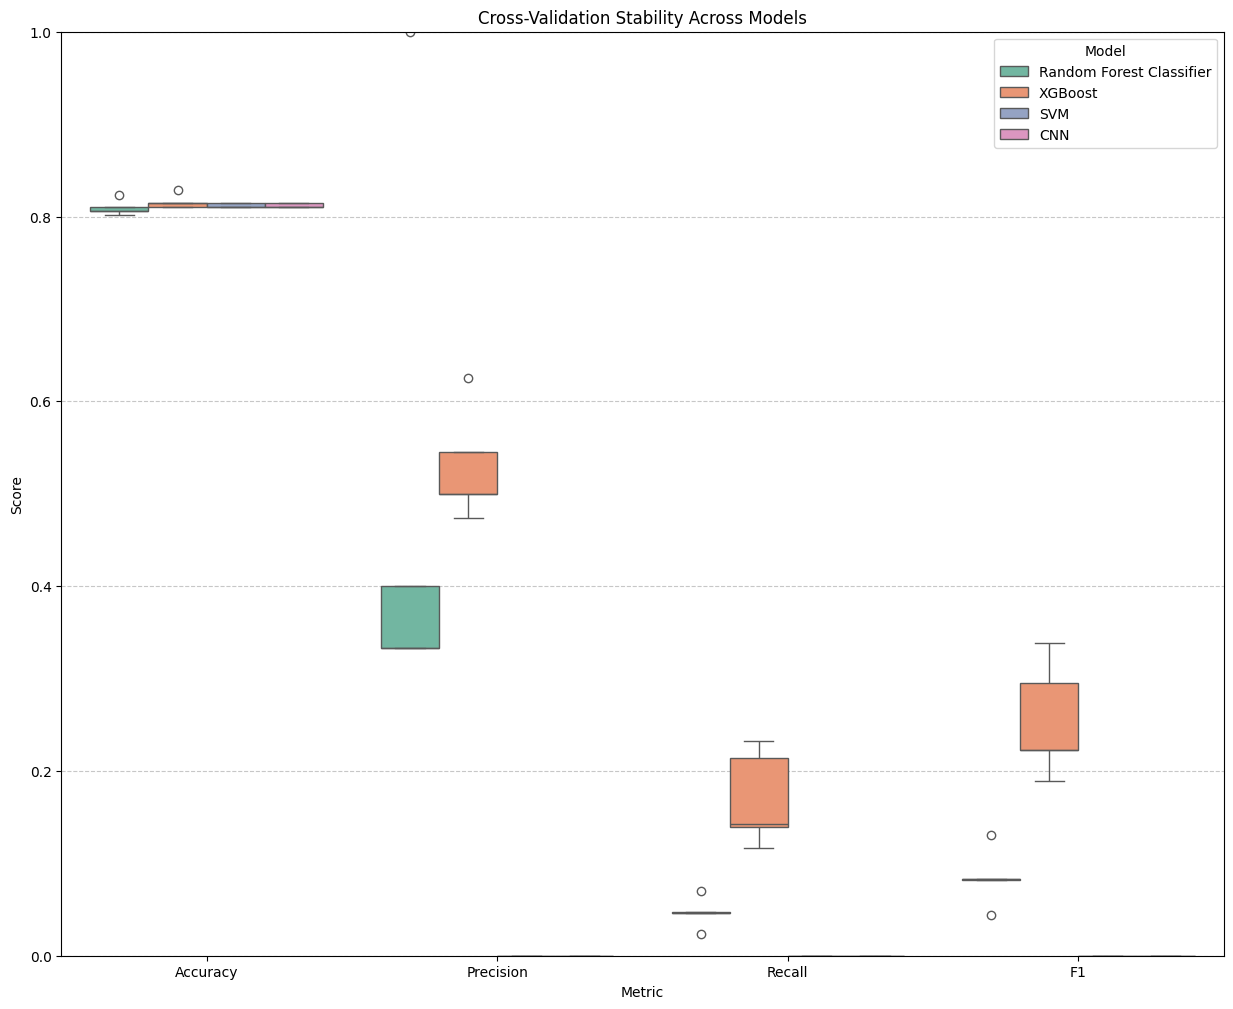


 Decision Tree
 Mean Accuracy Score: 0.7551 + 0.0220
 Mean F1 Score: 0.2199 + 0.0355
 Mean ROC_AUC: 0.5661 + 0.0493


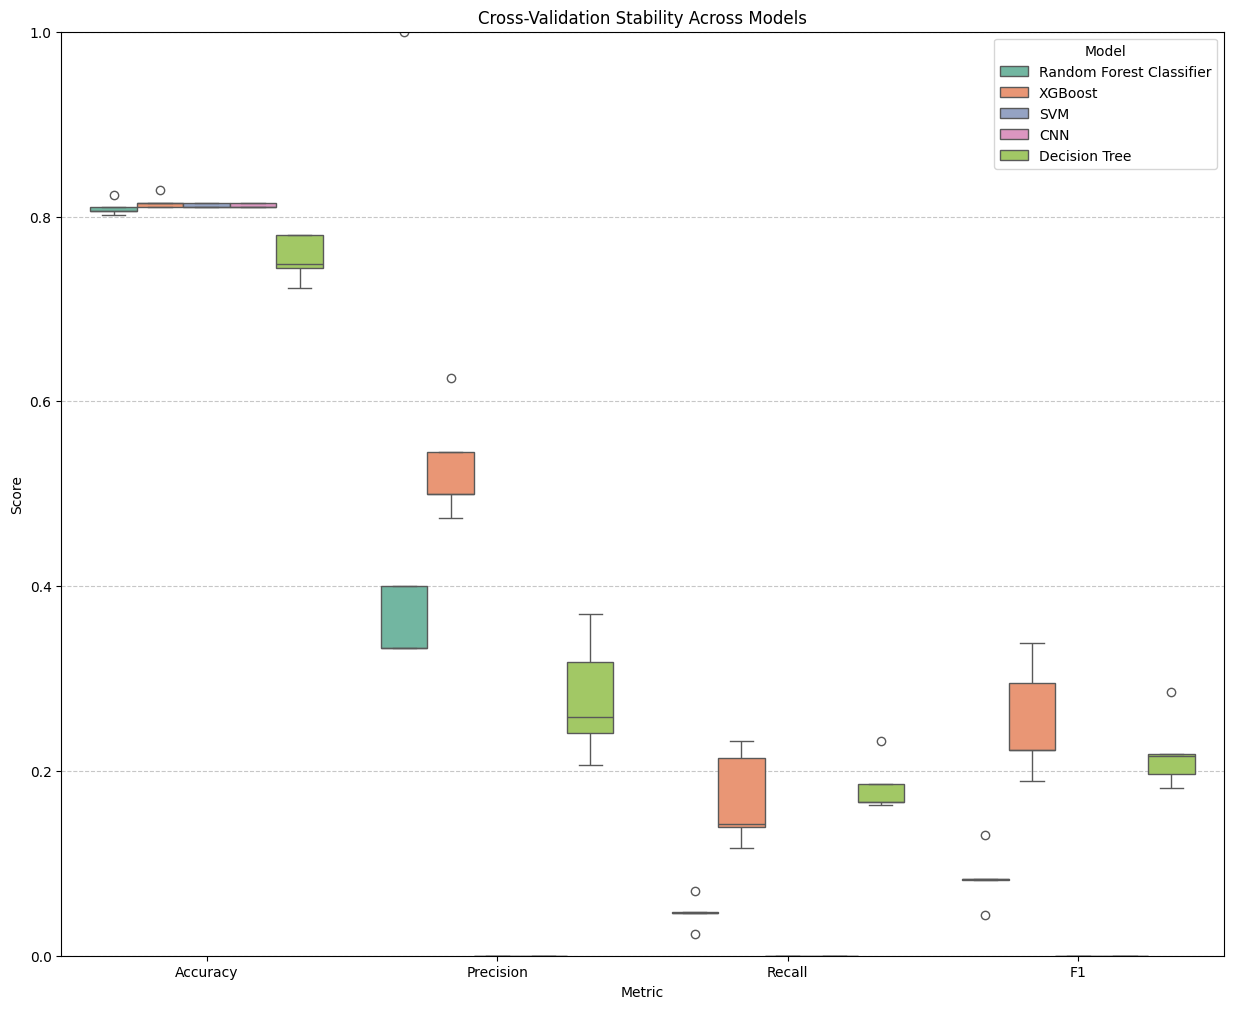


 [Step 10] SHAP and Grad-CAM Analysis


✓ Models loaded from 'models/' directory
Running: xgboost


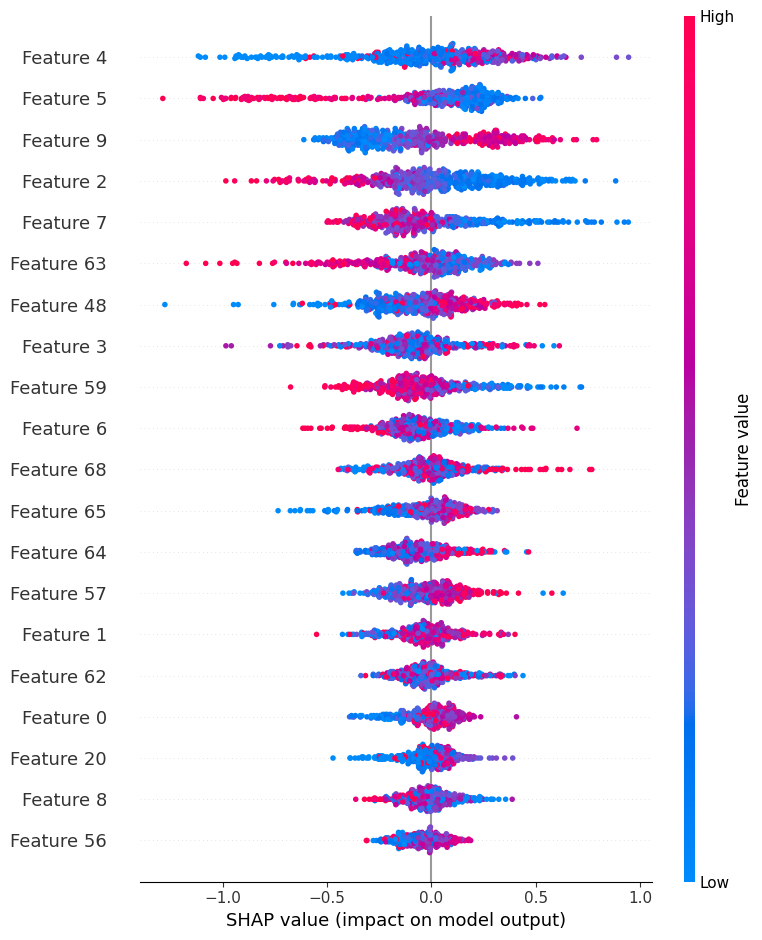

Running: random_forest


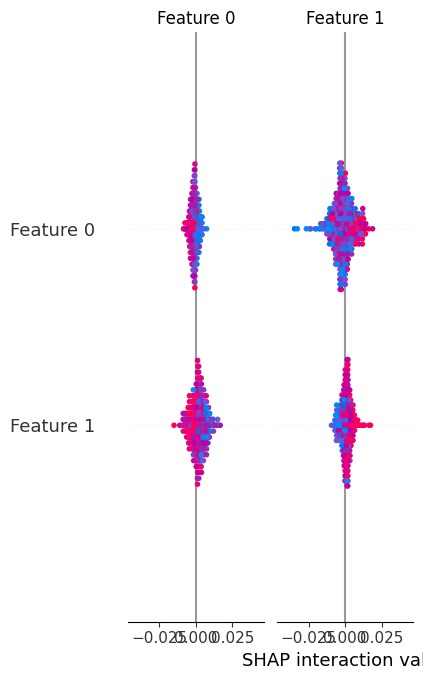

Running: svm


100%|██████████| 50/50 [18:04<00:00, 21.68s/it]


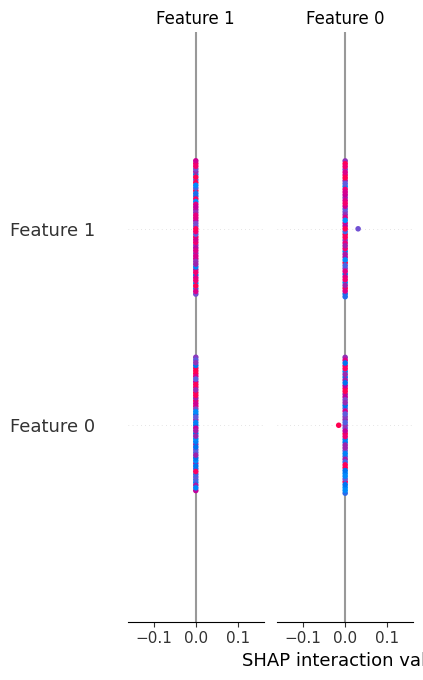

Running: cnn
Last layer name in CNN: block5_conv3


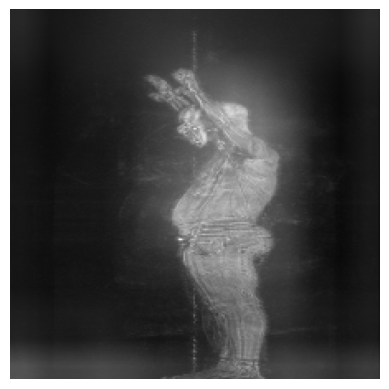

In [4]:
if __name__ == '__main__':
    main()